In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset, DatasetDict
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/My Drive/CS 6220/Project/inference' # Change the path to the folder where the project is stored in Google Drive.

# Files in the folder -
os.listdir(folder_path)

os.chdir(folder_path)

print('Current working directory -', os.getcwd())

Current working directory - /content/drive/My Drive/CS 6220/Project/inference


# **Import Competition MATH Dataset**

In [5]:
ds = load_dataset("jeggers/competition_math", "original")

ds['train'] = ds['train'].filter(lambda example: example["level"] != "Level ?")
print(f"There are {len(ds['train'])+len(ds['test'])} addition questions and answers")

train_ds = DatasetDict({
    'train': ds['train'],
    'test': ds['test']
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

There are 12498 addition questions and answers


In [6]:
def add_index(ds_entry, idx):
    ds_entry['id'] = idx
    return ds_entry

ds['test'] = ds['test'].map(lambda ds_entry, idx: add_index(ds_entry, idx), with_indices=True)
print(ds['test'][0])

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

{'problem': 'How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have?', 'level': 'Level 3', 'type': 'Algebra', 'solution': 'The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\\boxed{2}$ vertical asymptotes.', 'extracted_solution': '2', 'id': 0}


In [7]:
print(type(ds['test'][123]['extracted_solution']))

<class 'str'>


# **Model #1: Llama 3.1**

In [22]:
import pandas as pd

llama_correct_answers = [False] * len(ds['test'])
df = pd.read_csv('inference_llama3_competition_math.csv')
print(type(df.iloc[0]['Run_1']))

for i in range(len(ds['test'])):
  if ds['test'][i]['extracted_solution'] == df.iloc[i]['Run_1']:
    llama_correct_answers[i] = True

print(f"Number of correct questions: {sum(llama_correct_answers)}")

<class 'str'>
Number of correct questions: 798


Llama's number of correct answers for math competition dataset

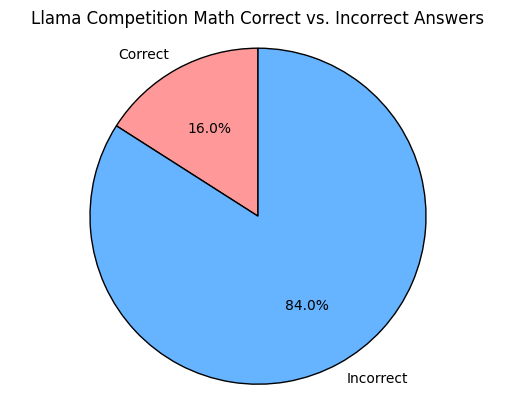

In [23]:
import matplotlib.pyplot as plt
labels = ['Correct', 'Incorrect']
sizes = [sum(llama_correct_answers), len(ds['test']) - sum(llama_correct_answers)]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Llama Competition Math Correct vs. Incorrect Answers')

plt.show()

In-depth Analysis in Algebra answers

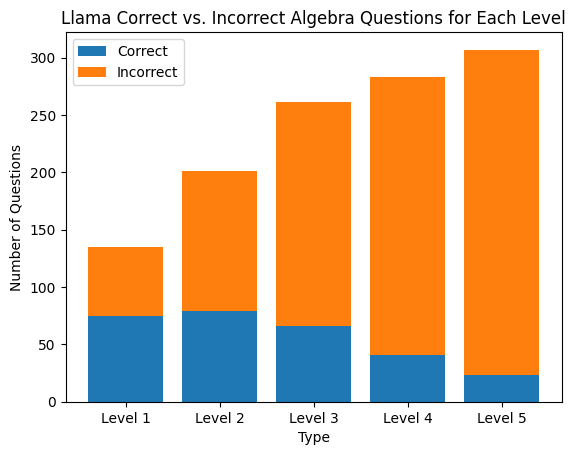

In [24]:
import numpy as np

total = [0] * 5
correct = [0] * 5

def get_problem_level(problem_level):
  if problem_level == "Level 1":
    return 0
  elif problem_level == "Level 2":
    return 1
  elif problem_level == "Level 3":
    return 2
  elif problem_level == "Level 4":
    return 3
  else:
    return 4

for i in range(len(ds['test'])):
  if ds['test'][i]['type'] == "Algebra":

    problem_level = get_problem_level(ds['test'][i]['level'])
    total[problem_level] += 1
    if llama_correct_answers[i] == True:
      correct[problem_level] += 1

incorrect = np.array(total) - np.array(correct)
levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

fig, ax = plt.subplots()
ax.bar(range(len(total)), correct, label='Correct')
ax.bar(levels, incorrect, bottom=correct, label='Incorrect')

ax.set_xlabel('Type')
ax.set_ylabel('Number of Questions')
ax.set_title('Llama Correct vs. Incorrect Algebra Questions for Each Level')
ax.legend()
plt.show()


# **Model #2: LLemma**

In [19]:
llemma_correct_answers = [False] * len(ds['test'])
file = open('llemma_competition_math_extracted_answers_2.txt', 'r')

for i in range(4961):
  answer = eval(file.readline())
  if ds['test'][i]['extracted_solution'] == answer['Final Solution']:
    llemma_correct_answers[i] = True

print(f"Number of correct questions: {sum(llemma_correct_answers)}")

Number of correct questions: 507


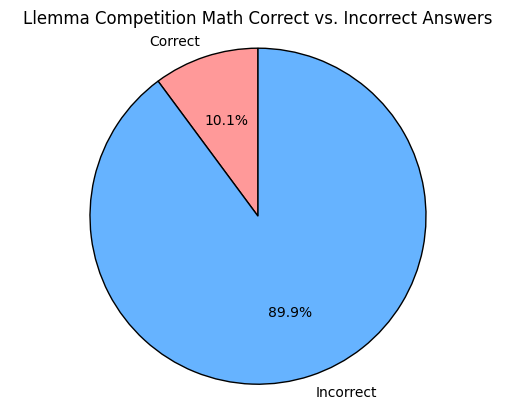

In [20]:
import matplotlib.pyplot as plt
labels = ['Correct', 'Incorrect']
sizes = [sum(llemma_correct_answers), len(ds['test']) - sum(llemma_correct_answers)]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Llemma Competition Math Correct vs. Incorrect Answers')

plt.show()

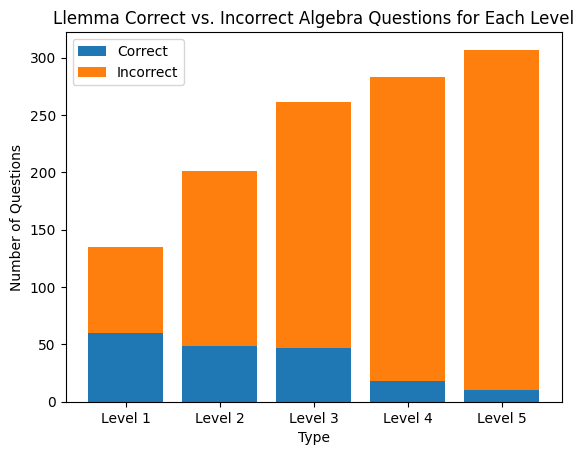

In [21]:
import numpy as np

total = [0] * 5
correct = [0] * 5

def get_problem_level(problem_level):
  if problem_level == "Level 1":
    return 0
  elif problem_level == "Level 2":
    return 1
  elif problem_level == "Level 3":
    return 2
  elif problem_level == "Level 4":
    return 3
  else:
    return 4

for i in range(len(ds['test'])):
  if ds['test'][i]['type'] == "Algebra":

    problem_level = get_problem_level(ds['test'][i]['level'])
    total[problem_level] += 1
    if llemma_correct_answers[i] == True:
      correct[problem_level] += 1

incorrect = np.array(total) - np.array(correct)
levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

fig, ax = plt.subplots()
ax.bar(range(len(total)), correct, label='Correct')
ax.bar(levels, incorrect, bottom=correct, label='Incorrect')

ax.set_xlabel('Type')
ax.set_ylabel('Number of Questions')
ax.set_title('Llemma Correct vs. Incorrect Algebra Questions for Each Level')
ax.legend()
plt.show()

# **Model #3: Qwen**

In [16]:
qwen_correct_answers = [False] * len(ds['test'])
df = pd.read_csv('inference_QWEN_competition_math.csv')
print(type(df.iloc[0]['Run_1']))

for i in range(len(ds['test'])):
  if ds['test'][i]['extracted_solution'] == df.iloc[i]['Run_1']:
    qwen_correct_answers[i] = True

print(f"Number of correct questions: {sum(qwen_correct_answers)}")

<class 'str'>
Number of correct questions: 1851


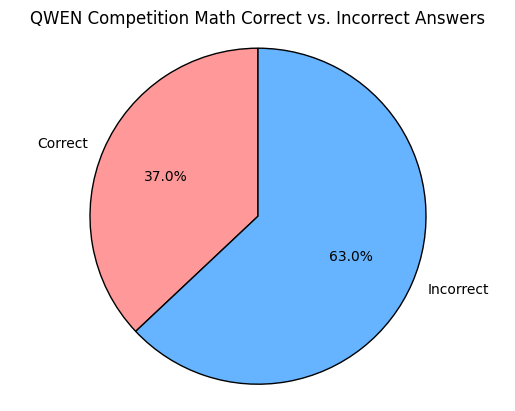

In [17]:
import matplotlib.pyplot as plt
labels = ['Correct', 'Incorrect']
sizes = [sum(qwen_correct_answers), len(ds['test']) - sum(qwen_correct_answers)]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('QWEN Competition Math Correct vs. Incorrect Answers')

plt.show()

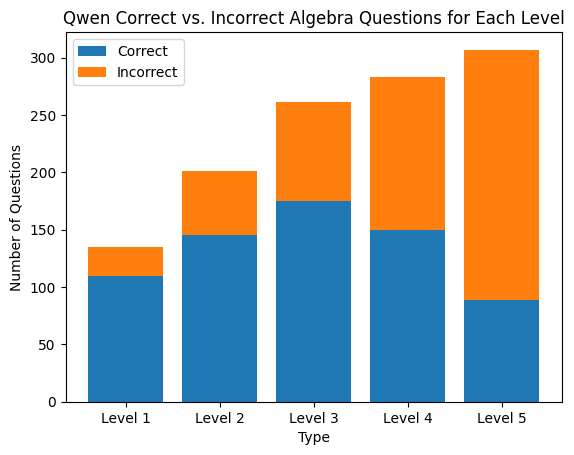

In [18]:
total = [0] * 5
correct = [0] * 5

def get_problem_level(problem_level):
  if problem_level == "Level 1":
    return 0
  elif problem_level == "Level 2":
    return 1
  elif problem_level == "Level 3":
    return 2
  elif problem_level == "Level 4":
    return 3
  else:
    return 4

for i in range(len(ds['test'])):
  if ds['test'][i]['type'] == "Algebra":

    problem_level = get_problem_level(ds['test'][i]['level'])
    total[problem_level] += 1
    if qwen_correct_answers[i] == True:
      correct[problem_level] += 1

incorrect = np.array(total) - np.array(correct)
levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

fig, ax = plt.subplots()
ax.bar(range(len(total)), correct, label='Correct')
ax.bar(levels, incorrect, bottom=correct, label='Incorrect')

ax.set_xlabel('Type')
ax.set_ylabel('Number of Questions')
ax.set_title('Qwen Correct vs. Incorrect Algebra Questions for Each Level')
ax.legend()
plt.show()

# **Model #4: Mistral**

In [10]:
import pandas as pd

mistral_correct_answers = [False] * len(ds['test'])
df = pd.read_csv('Mistral_Inference_Competition_Dataset.csv')

for i in range(len(ds['test'])):
  if ds['test'][i]['extracted_solution'] == df.iloc[i]['Run_1']:
    mistral_correct_answers[i] = True

print(f"Number of correct questions: {sum(mistral_correct_answers)}")

Number of correct questions: 179


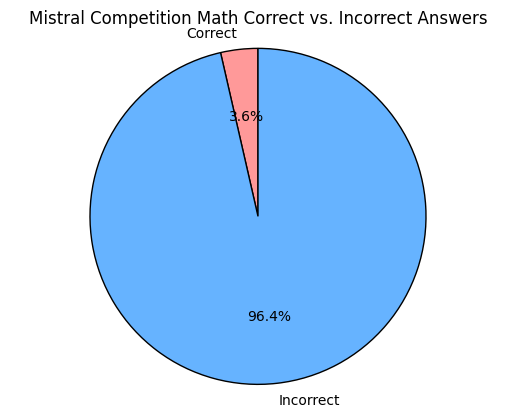

In [12]:
import matplotlib.pyplot as plt
labels = ['Correct', 'Incorrect']
sizes = [sum(mistral_correct_answers), len(ds['test']) - sum(mistral_correct_answers)]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Mistral Competition Math Correct vs. Incorrect Answers')

plt.show()

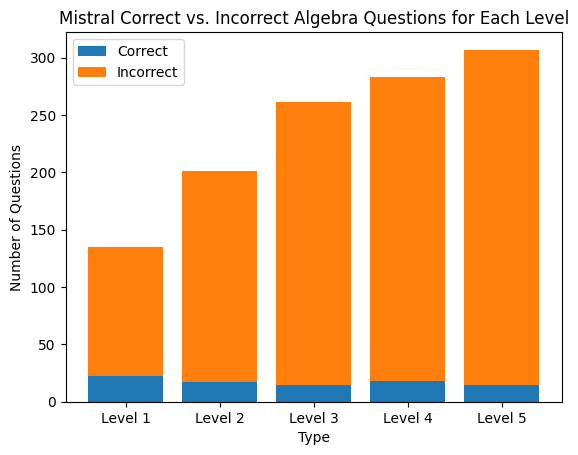

In [15]:
import numpy as np

total = [0] * 5
correct = [0] * 5

def get_problem_level(problem_level):
  if problem_level == "Level 1":
    return 0
  elif problem_level == "Level 2":
    return 1
  elif problem_level == "Level 3":
    return 2
  elif problem_level == "Level 4":
    return 3
  else:
    return 4

for i in range(len(ds['test'])):
  if ds['test'][i]['type'] == "Algebra":

    problem_level = get_problem_level(ds['test'][i]['level'])
    total[problem_level] += 1
    if mistral_correct_answers[i] == True:
      correct[problem_level] += 1

incorrect = np.array(total) - np.array(correct)
levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

fig, ax = plt.subplots()
ax.bar(range(len(total)), correct, label='Correct')
ax.bar(levels, incorrect, bottom=correct, label='Incorrect')

ax.set_xlabel('Type')
ax.set_ylabel('Number of Questions')
ax.set_title('Mistral Correct vs. Incorrect Algebra Questions for Each Level')
ax.legend()
plt.show()

# **Model Comparison**
1. Compare which questions that two models got correct and two models got incorrect
2. Compare which questions that three models got correct and one model got incorrect
3. Compare which questions that one model got correct and three got incorrect

In [28]:
total_correct = [[0, 0, 0, 0] for i in range(len(ds['test']))]

for i in range(len(ds['test'])):
  if llama_correct_answers[i] == True:
    total_correct[i][0] = 1

  if llemma_correct_answers[i] == True:
    total_correct[i][1] = 1

  if qwen_correct_answers[i] == True:
    total_correct[i][2] = 1

  if mistral_correct_answers[i] == True:
    total_correct[i][3] = 1

rows_sum = np.sum(np.array(total_correct), axis = 1)

questions = [0,0,0,0,0]
for i in range(len(questions)):
  questions[i] = np.count_nonzero(rows_sum == i)

print("Number of questions one model got correct: " + str(questions[1]))
print("Number of questions two models got correct: " + str(questions[2]))
print("Number of questions three models got correct: " + str(questions[3]))

Number of questions one model got correct: 1395
Number of questions two models got correct: 552
Number of questions three models got correct: 236


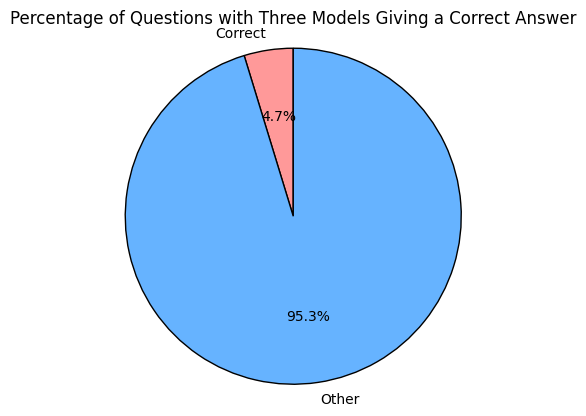

In [49]:
import matplotlib.pyplot as plt
labels = ['Correct', 'Other']
sizes = [questions[3], len(ds['test']) - questions[3]]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Percentage of Questions with Three Models Giving a Correct Answer')

plt.show()

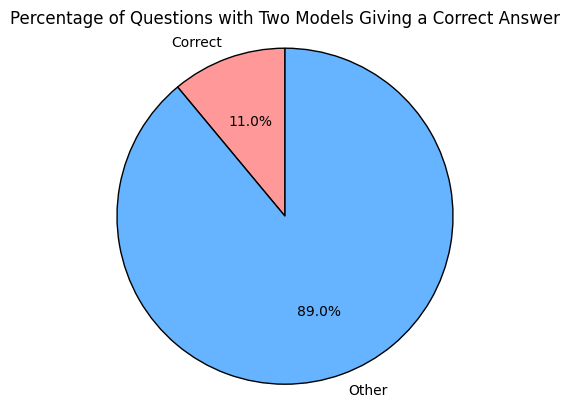

In [48]:
labels = ['Correct', 'Other']
sizes = [questions[2], len(ds['test']) - questions[2]]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Percentage of Questions with Two Models Giving a Correct Answer')

plt.show()

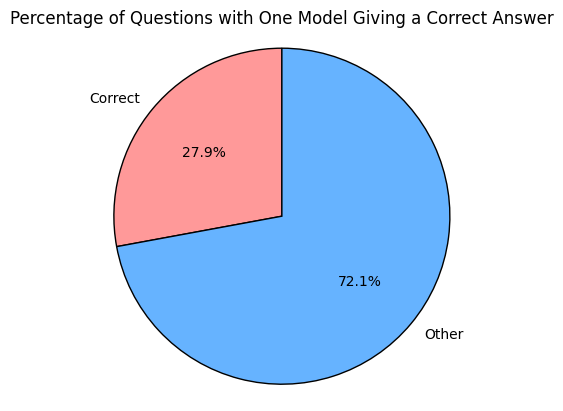

In [47]:
labels = ['Correct', 'Other']
sizes = [questions[1], len(ds['test']) - questions[1]]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Percentage of Questions with One Model Giving a Correct Answer')

plt.show()

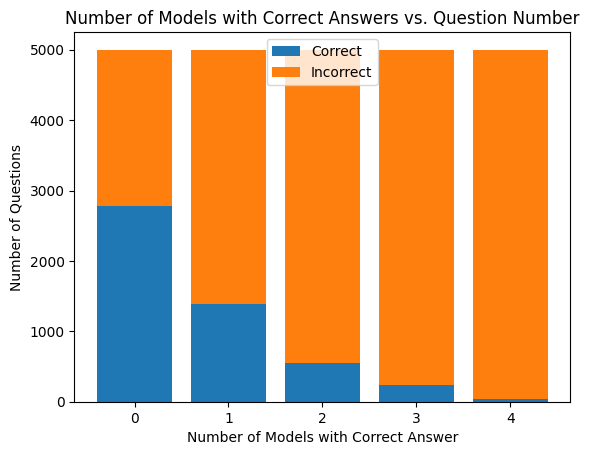

In [45]:
total = [len(ds['test'])]*5
incorrect = np.array(total) - np.array(questions)
num_models = ['0', '1', '2', '3', '4']

fig, ax = plt.subplots()
ax.bar(range(len(total)), questions, label='Correct')
ax.bar(num_models, incorrect, bottom=questions, label='Incorrect')

ax.set_xlabel('Number of Models with Correct Answer')
ax.set_ylabel('Number of Questions')
ax.set_title('Number of Models with Correct Answers vs. Question Number')
ax.legend()
plt.show()

In [70]:
question_idx_one_correct = np.where(rows_sum == 1)
#print(question_idx_one_correct)

print("Question: " + str(ds['test'][2]['problem']))
print("Correct Answer: " + str(ds['test'][2]['extracted_solution']) + '\n')

df = pd.read_csv('Mistral_Inference_Competition_Dataset.csv')
print("Mistral's Answer: " + df.iloc[2]['Run_1'])

df = pd.read_csv('inference_QWEN_competition_math.csv')
print("Qwen's Answer: " + df.iloc[2]['Run_1'])

df = pd.read_csv('inference_llama3_competition_math.csv')
print("Llama's Answer: " + df.iloc[2]['Run_1'])

file = open('llemma_competition_math_extracted_answers_2.txt', 'r')
for i in range(3):
  answer = eval(file.readline())
  if (i == 2):
    print("Llemma's Answer: " + str(answer['Final Solution']))

Question: Find $x$ such that $\lceil x \rceil + x = \dfrac{23}{7}$. Express $x$ as a common fraction.
Correct Answer: \dfrac{9}{7}

Mistral's Answer: \dfrac{1}{7}
Qwen's Answer: \dfrac{9}{7}
Llama's Answer: Error Parsing Response
Llemma's Answer: None


In [76]:
question_idx_one_correct = np.where(rows_sum == 2)
#print(question_idx_one_correct)

print("Question: " + str(ds['test'][264]['problem']))
print("Correct Answer: " + str(ds['test'][264]['extracted_solution']) + '\n')
print(str(ds['test'][264]['level']))
print(str(ds['test'][264]['type']))

df = pd.read_csv('Mistral_Inference_Competition_Dataset.csv')
print("Mistral's Answer: " + df.iloc[264]['Run_1'])

df = pd.read_csv('inference_QWEN_competition_math.csv')
print("Qwen's Answer: " + df.iloc[264]['Run_1'])

df = pd.read_csv('inference_llama3_competition_math.csv')
print("Llama's Answer: " + df.iloc[264]['Run_1'])

file = open('llemma_competition_math_extracted_answers_2.txt', 'r')
for i in range(265):
  answer = eval(file.readline())
  if (i == 264):
    print("Llemma's Answer: " + str(answer['Final Solution']))

Question: If $\&x$ is defined as $\&x = x + 5$ and $\#x$ is defined as $\#x = x^2$ , what is the value of $\#(\&4)$?
Correct Answer: 81

Level 2
Algebra
Mistral's Answer: 6
Qwen's Answer: 81
Llama's Answer: 81
Llemma's Answer: 81
